In [1]:
import tensorflow as tf
import os
import re
import pandas as pd
import numpy as np
from glob import glob
from numpy import array
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.applications import InceptionV3
import pickle

In [2]:
""" # FLICKR8K
DATA_CAP_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
DATA_IMG_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'

# DATA SAVE FOLDERS
CAP_FOLDER = '/'
IMG_FOLDER = '/Flicker8k_Dataset/' """

" # FLICKR8K\nDATA_CAP_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'\nDATA_IMG_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'\n\n# DATA SAVE FOLDERS\nCAP_FOLDER = '/'\nIMG_FOLDER = '/Flicker8k_Dataset/' "

In [3]:
""" def download_images():
  # Download caption annotation files
  # It's lightweight.. we can download it everytime :P
  cap_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                        cache_subdir = os.path.abspath('.'),
                                        origin = DATA_CAP_ORIGIN,
                                        extract = True)
  caption_path = os.path.dirname(cap_zip)+CAP_FOLDER+'Flickr8k.token.txt'

  #REMOVE ZIP THING
  os.remove(cap_zip)
    
  if not os.path.exists(os.path.abspath('.') + IMG_FOLDER):
    image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = DATA_IMG_ORIGIN,
                                        extract = True)
    image_path = os.path.dirname(image_zip) + IMG_FOLDER
    
    #REMOVE ZIP THING
    os.remove(image_zip)

  else:
    image_path = os.path.abspath('.') + IMG_FOLDER

  img_lists = []

  # load image lists
  for imgfile in os.listdir(image_path):
    filename = os.fsdecode(imgfile)
    img_lists.append(image_path+filename)

  return caption_path, image_path, img_lists """

" def download_images():\n  # Download caption annotation files\n  # It's lightweight.. we can download it everytime :P\n  cap_zip = tf.keras.utils.get_file('Flickr8k_text.zip',\n                                        cache_subdir = os.path.abspath('.'),\n                                        origin = DATA_CAP_ORIGIN,\n                                        extract = True)\n  caption_path = os.path.dirname(cap_zip)+CAP_FOLDER+'Flickr8k.token.txt'\n\n  #REMOVE ZIP THING\n  os.remove(cap_zip)\n    \n  if not os.path.exists(os.path.abspath('.') + IMG_FOLDER):\n    image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',\n                                        cache_subdir=os.path.abspath('.'),\n                                        origin = DATA_IMG_ORIGIN,\n                                        extract = True)\n    image_path = os.path.dirname(image_zip) + IMG_FOLDER\n    \n    #REMOVE ZIP THING\n    os.remove(image_zip)\n\n  else:\n    image_path = os.path.abspath('.') + IMG

In [4]:
caption_path = os.path.abspath('.') + '/captions.txt'
image_path = os.path.abspath('.') + '/images/'
img_lists = []
 # load image lists
for imgfile in os.listdir(image_path):
    filename = os.fsdecode(imgfile)
    img_lists.append(image_path+filename)

In [5]:
caption_path

'c:\\Users\\Kalle\\Desktop\\code\\AI_in3\\Example_Image_Captioning/captions.txt'

In [6]:
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12892668229700000848
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6940786688
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18000357429207266210
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [7]:
image_path

'c:\\Users\\Kalle\\Desktop\\code\\AI_in3\\Example_Image_Captioning/images/'

In [8]:
img_lists[1]

'c:\\Users\\Kalle\\Desktop\\code\\AI_in3\\Example_Image_Captioning/images/10002456.jpg'

One example of the dataset :)

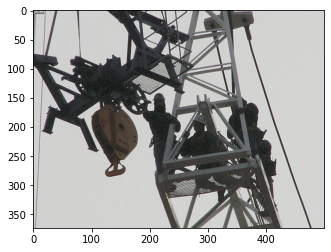

In [9]:
img = mpimg.imread(img_lists[1])
imgplot = plt.imshow(img)
plt.show()

In [10]:
captions = open(caption_path, 'r',  encoding="utf8").read().strip().split('\n')

In [11]:
start = '<start> '
end = ' <end>'

data_map = {}
for line in captions:
    token = line.split('|')
    image_id = token[0]
    image_caption = ' ' + token[2]
        
    if(image_id not in data_map):
        data_map[image_id] = list()

    data_map[image_id].append(start + image_caption + end)

print(len(data_map))     
print(data_map['1989609.jpg'])
print(data_map['3367399.jpg'])

31783
['<start>  A man wearing blue coveralls is handing a tool to another person . <end>', '<start>  A man in a navy blue jacket holding a tool in his dirty hand . <end>', '<start>  A man in a work uniform passing a tool to another person . <end>', '<start>  Man in a blue jumpsuit attempts to repair an escalator . <end>', '<start>  A man with a mustache works on a broken escalator . <end>']
['<start>  A man in a jacket is standing in a gas station , next to a car and lights are shining in the distance . <end>', '<start>  A man in a tan jacket at the gas station pumping gas . <end>', '<start>  The man is filling his car with gasoline . <end>', '<start>  A man pumping gas at a gas station . <end>', '<start>  A man dressed in tan pumps gas . <end>']


In [12]:
# Cleanse and pre-process the data

def cleanse_data(data):
    dict = {}
    for key, value in data.items():
        for cap in value: 
            lines = ''
            for i in cap.split():
                if len(i) < 3:
                    continue
                i = i.lower()
                lines += i + ' '
            if(key not in dict):
                dict[key] = list()
            
            dict[key].append(lines)
    return dict

data2 = cleanse_data(data_map)
print(len(data2))   
print(data2['1989609.jpg'])
print(data2['3367399.jpg']) 
all_images = list(data2.keys())
all_captions = list()
for l in data2.values():
    for s in l:
        all_captions.append(s)


31783
['<start> man wearing blue coveralls handing tool another person <end> ', '<start> man navy blue jacket holding tool his dirty hand <end> ', '<start> man work uniform passing tool another person <end> ', '<start> man blue jumpsuit attempts repair escalator <end> ', '<start> man with mustache works broken escalator <end> ']
['<start> man jacket standing gas station next car and lights are shining the distance <end> ', '<start> man tan jacket the gas station pumping gas <end> ', '<start> the man filling his car with gasoline <end> ', '<start> man pumping gas gas station <end> ', '<start> man dressed tan pumps gas <end> ']


In [13]:
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
print(model.layers[-1].output.shape)
print(model.input.shape)
CNN = tf.keras.models.Model(model.input, model.layers[-1].output)
CNN.trainable = False

(None, 2048)
(None, None, None, 3)


In [14]:
def load_preprocess(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(299, 299))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    return img

def encode(image):
    img = load_preprocess(image)
    pred = CNN(img)
    #print(pred.shape)
    pred = np.reshape(pred, pred.shape[1])
    #print(pred.shape)
    return pred

def encode_all(data):
    X = []
    y = []
    for img, desc in tqdm(data.items()):
        img_enc = encode(image_path + img)
        for cap in desc:
            X.append(img_enc)
            y.append(cap)
        
    return X, y

In [15]:
data_X, data_y = encode_all(data2)

  0%|          | 0/31783 [00:00<?, ?it/s]

In [ ]:

with open('data_X_enc.txt', 'wb') as fh:
   pickle.dump(data_X, fh)

with open('data_y.txt', 'wb') as p:
   pickle.dump(data_y, p)

In [ ]:
pickle_X = open ("data_X_enc.txt", "rb")
images_enc = pickle.load(pickle_X)

pickle_y = open ("data_y.txt", "rb")
text = pickle.load(pickle_y)

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<unk>', filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(text)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

token_start = tokenizer.word_index[start.strip()]
token_end = tokenizer.word_index[end.strip()]

all_captions_seq = tokenizer.texts_to_sequences(text)

all_captions_seq = tf.keras.preprocessing.sequence.pad_sequences(all_captions_seq, padding='post')

vocab_size = len(tokenizer.word_index) + 1
max_cap_len = len(all_captions_seq[0])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(images_enc, all_captions_seq, test_size=0.2)
print(y_train[1])
print(tokenizer.sequences_to_texts([y_train[1]]))
print(y_train[2])
print(tokenizer.sequences_to_texts([y_train[2]]))



[   2    6   16   13  747  119   62 6810    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
['<start> man black shirt happy hand out cds <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
[ 2 15  8 45  4 83 12 51  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
['<start> young woman outside the snow wearing hat <end> <pad> <pad

In [ ]:
def map_func(img_encode, cap):
    x = {'text': cap[0:-1],'image': img_encode}
    y = {'output': cap[1:]}
    
    return x,y

In [ ]:
BATCH_SIZE = 64
SHUFFLE_VALUE = 256

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
train_dataset = train_dataset.map(map_func)
valid_dataset = valid_dataset.map(map_func)
train_dataset = train_dataset.shuffle(SHUFFLE_VALUE).batch(BATCH_SIZE)
valid_dataset = valid_dataset.shuffle(SHUFFLE_VALUE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow import keras

#encoder
enc_in = keras.layers.Input(shape=(2048,),name='image')
enc_2 = keras.layers.Dense(1024, activation='relu')(enc_in)
enc_3 = keras.layers.Dense(512, activation='relu')(enc_2)
#RNN
dec_in = keras.layers.Input(shape=(None, ), name='text')
dec_1 = keras.layers.Embedding(vocab_size, 1024, mask_zero=True)(dec_in)
dec_3 = keras.layers.GRU(1024, return_sequences=True)(dec_in)
dec_5 = keras.layers.GRU(512, return_sequences=True)(dec_3)
#decoder
dec_mix = keras.layers.add([enc_3, dec_5])
dec_mix_2 = keras.layers.Dense(512, activation='relu')(dec_mix)
dec_mix_3 = keras.layers.Dense(1024, activation='relu')(dec_mix_2)
dec_out = keras.layers.Dense(vocab_size, activation='softmax', name='output')(dec_mix_3)

model_1 = keras.models.Model(inputs=[enc_in, dec_in], outputs=[dec_out])

model_1.summary()


NameError: name 'vocab_size' is not defined

In [ ]:
model_1.compile(
    optimizer=tf.keras.optimizers.RMSprop(), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],)

history = model_1.fit(train_dataset, validation_data=valid_dataset, epochs=20, validation_steps=2)

Epoch 1/5
1987/1987 [==============================] - 209s 103ms/step - loss: 0.6547 - accuracy: 0.3166 - val_loss: 0.6305 - val_accuracy: 0.3260
Epoch 2/5
1987/1987 [==============================] - 202s 101ms/step - loss: 0.6640 - accuracy: 0.3186 - val_loss: 0.6740 - val_accuracy: 0.3124
Epoch 3/5
1987/1987 [==============================] - 199s 100ms/step - loss: 0.6659 - accuracy: 0.3201 - val_loss: 0.6571 - val_accuracy: 0.3272
Epoch 4/5
1987/1987 [==============================] - 199s 100ms/step - loss: 0.6664 - accuracy: 0.3215 - val_loss: 0.6615 - val_accuracy: 0.3268
Epoch 5/5
1987/1987 [==============================] - 200s 101ms/step - loss: 0.6653 - accuracy: 0.3225 - val_loss: 0.6671 - val_accuracy: 0.3167


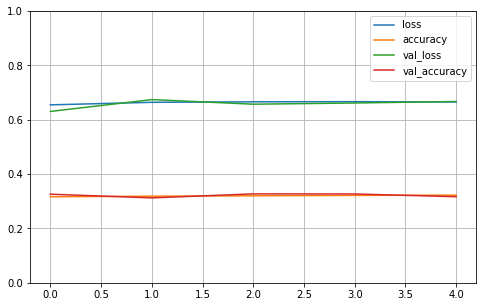

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()
model_1.save("my_model.h5")

In [ ]:
model_1 = tf.keras.models.load_model("my_model.h5")

5. Evaluation with fun pics
 - Bring five images you like from anywhere, but not from your datasets, and generate captions.

In [ ]:
def generate_caption(image_url):
    image = tf.keras.utils.get_file(origin=image_url)
    encoder_input = encode(image)
    encoder_input = np.expand_dims(encoder_input, axis=0)
    shape = (1, max_cap_len)
    decoder_input = np.zeros(shape=shape, dtype=int)
    token_id = token_start
    output=[]
    count_tokens = 0

    while token_id != token_end and count_tokens < max_cap_len:
        decoder_input[0, count_tokens] = token_id
        input_data ={'text' : decoder_input,'image':encoder_input}
        predict = model_1.predict(input_data)
        token_id = np.argmax(predict[0, count_tokens, :])
        output.append(token_id)
        count_tokens += 1
    
    tokenized = tokenizer.sequences_to_texts([output])
    print('Predicted caption : ', tokenized[0])
    x = mpimg.imread(image)
    x = plt.imshow(x)
    plt.show()

Predicted caption :  man surfing wave <end>


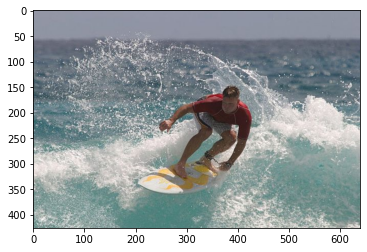

In [ ]:
generate_caption('https://tensorflow.org/images/surf.jpg')

Predicted caption :  man wearing blue shirt and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue pants and blue


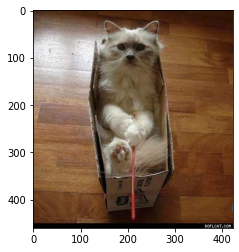

In [ ]:

generate_caption('https://i.pinimg.com/originals/05/d5/0b/05d50bdae37f556cf540ab1b456d559b.jpg')


Predicted caption :  dog running through the grass <end>


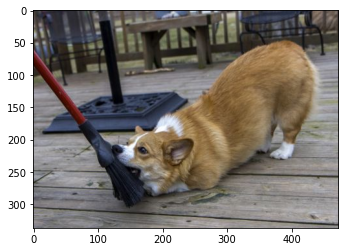

In [ ]:
generate_caption('https://i.pinimg.com/474x/6e/76/96/6e7696bd00cfca3ca3c9955b574e626a.jpg')


Predicted caption :  man riding bike <end>


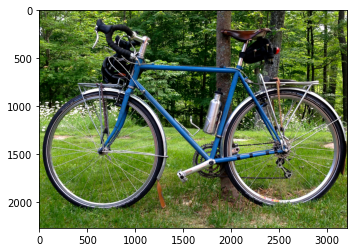

In [ ]:
generate_caption('https://images.huffingtonpost.com/2014-07-03-Bike.JPG')


Predicted caption :  two men are standing the water <end>


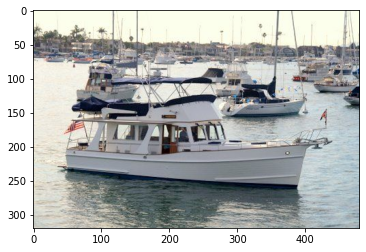

In [ ]:

generate_caption('https://i.pinimg.com/originals/99/21/6a/99216aa8f2e9af5d1096796e75c9e510.jpg')
